# 🐸 AnuraSet Audio Lab 1

**Data Exploration with Python**

The first portion of this workshop involves getting familiar with *agile modeling*, a framework for efficiently training new machine learning classifiers. In this workshop, you play the role of a herpetologist who has returned from field work in Brazil with a large collection of audio recordings of frog species. You are hoping to use agile modeling to quickly tell you which audio files contain a species that is of interest to you.

You have already used the agile modeling codebase to extract *embeddings* for a portion of this audio (which for this workshop is represented by the [AnuraSet](https://github.com/soundclim/anuraset) dataset). It now remains to pick your favorite species and train a new machine learning model to classify whether or not each embedding contains that species.

Agile modeling is a *human-in-the-loop* approach to doing so. We assume all of your data is unlabeled: you have no idea what each audio file contains. Agile modeling uses *active learning* to: (1) decide which data points in your collection should be labeled, and (2) ask you to label them. Active learning analyzes the structure of the *embedding space* to determine which data points will provide the most information once you label them. For instance, if many vocalizations sound similar to one another, and therefore form a *cluster* in the embedding space, it is possible that labeling a single data point in that cluster will tell you the species label of *all* points in that cluster. Active learning exploits structure like this, repeatedly querying for the labels of highly-informative data points.

In order to be an effective human in this loop, you'll need to know how to identify your favorite frog species by ear! In this notebook, you will train yourself to do so through *exploratory data analysis* of the AnuraSet dataset in Python. In doing so, you will practice some very common data exploration and analysis techniques that will assist you later in building your own classifier from scratch:

* manipulate CSV data with **pandas**
* visualize summaries with **matplotlib** and **seaborn**
* load & play audio clips with **librosa** / **IPython.display.Audio**
* plot spectrograms
* write a small object‑oriented wrapper for audio samples
* identify a frog species of your choosing using your own human brain! (Next time we will teach the machine)

We have provided an outline of this process below. Fill in the **📝 Exercise** sections yourself.
[NOTE: These are filled in with example solutions now; we can remove them before sending to students] 


In [1]:
# ------------------------------------------------------------
# SETUP - Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import Audio, display, clear_output
import ipywidgets as widgets
import librosa
import random
import os

In [2]:
# ------------------------------------------------------------
# DATA LOCATION - Change if you are using a different machine
# ------------------------------------------------------------
DATA_DIR = Path('/mnt/class_data/anuraset')
META_PATH = DATA_DIR / 'metadata.csv'
AUDIO_DIR = DATA_DIR / 'audio'

assert META_PATH.exists(), f"{META_PATH} does not exist. Update DATA_DIR!"


In [3]:
# ------------------------------------------------------------
# 📝 Exercise 0 – Load & inspect metadata
# ------------------------------------------------------------
# For this notebook, we will stray a little bit from our story that you are a herpetologist with a boatload of
# raw data. First we have to do some *human learning* (i.e., train you to identify frogs by ear). To do so, 
# we will take advantage of the data processing that has already been done by the creators of AnuraSet: namely
# the splitting of raw audio into 3-second chunks with detailed metadata about what species are present in
# each chunk. You will use these audio files to build a frog identification curriculum for yourself.
#
# The metadata is a CSV file located at META_PATH. 
# 
# 1. First, open it with pandas and take a look at the first few rows using the `head()` method. 
# Try to understand what each column might refer to; check out the AnuraSet paper 
# (https://www.nature.com/articles/s41597-023-02666-2) if anything is not clear.
# ------------------------------------------------------------
meta = None # TODO: Fill this in
if meta is not None:
    print(f"Loaded {len(meta):,} rows x {meta.shape[1]} columns")
    meta.head()

# ------------------------------------------------------------
## SOLUTION
# ------------------------------------------------------------
meta = pd.read_csv(META_PATH)
print(f"Loaded {len(meta):,} rows x {meta.shape[1]} columns")
meta.head()


Loaded 93,378 rows x 50 columns


,sample_name,fname,min_t,max_t,site,date,species_number,subset,SPHSUR,BOABIS,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
0,SAMPLE_00000.wav,INCT20955_20190904_003000,0,3,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
1,SAMPLE_00001.wav,INCT20955_20190904_003000,1,4,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
2,SAMPLE_00002.wav,INCT20955_20190904_003000,2,5,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
3,SAMPLE_00003.wav,INCT20955_20190904_003000,3,6,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
4,SAMPLE_00004.wav,INCT20955_20190904_003000,4,7,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# ------------------------------------------------------------
# Species indicator columns
# ------------------------------------------------------------
# In AnuraSet each species has its own binary column (1 = species vocalization
# present in the 3‑second sample).  Let's grab just those columns.
species_cols = meta.columns[8:]   # first 8 columns are meta‑info
print(f"Detected {len(species_cols)} species columns")
species_cols[:10]


Detected 42 species columns


Index(['SPHSUR', 'BOABIS', 'SCIPER', 'DENNAH', 'LEPLAT', 'RHIICT', 'BOALEP',
       'BOAFAB', 'PHYCUV', 'DENMIN'],
      dtype='object')

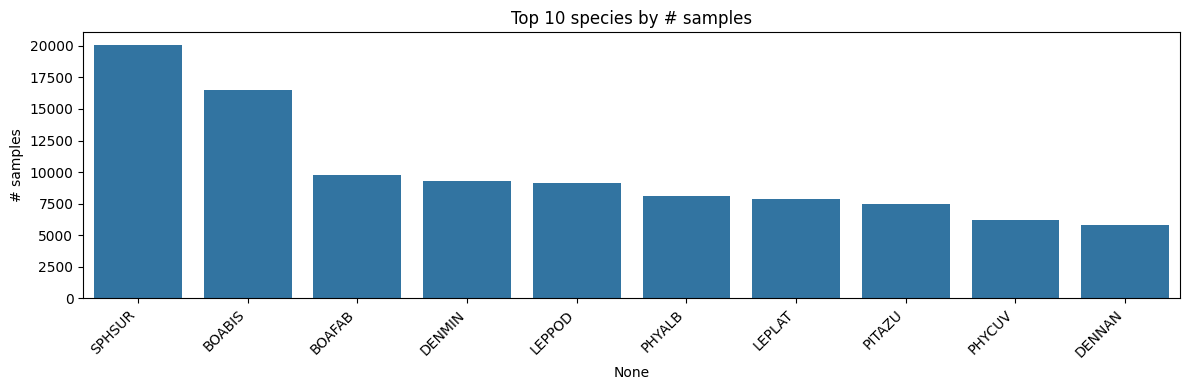

In [5]:
# ------------------------------------------------------------
# 📝 Exercise 1 – Count how many samples for each species
# ------------------------------------------------------------
# First, let's see how many example recordings of each species we are working with.
# 
# 1. First, create a pandas Series mapping species → number of positive samples.
# 2. Then, plot the counts of the top 10 most common species as a bar chart using matplotlib.
# ------------------------------------------------------------
species_counts = None

# ------------------------------------------------------------
## SOLUTION
# ------------------------------------------------------------
species_counts = meta[species_cols].sum().sort_values(ascending=False)

top_n = 10
plt.figure(figsize=(12,4))
sns.barplot(x=species_counts.head(top_n).index,
            y=species_counts.head(top_n).values)
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} species by # samples')
plt.ylabel('# samples')
plt.tight_layout()


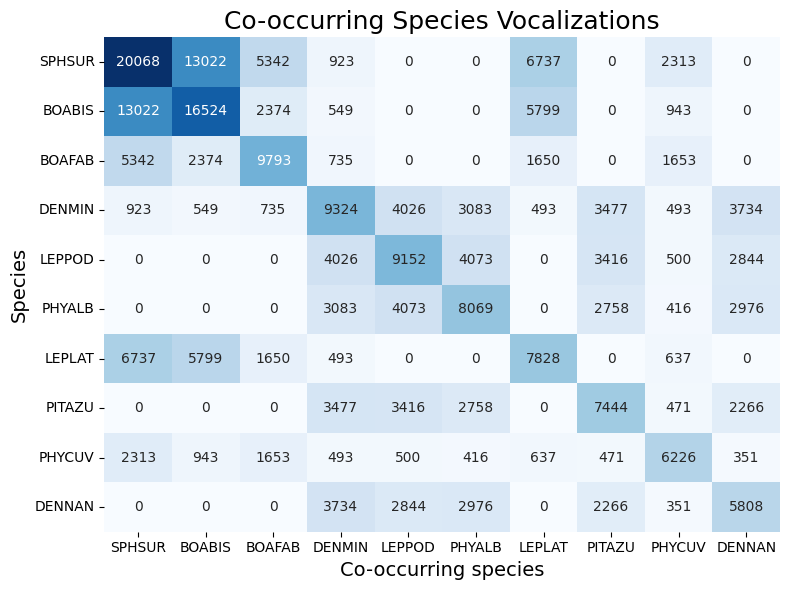

In [6]:
# ------------------------------------------------------------
# 📝 Exercise 2 – Inspect co-occurrance
# ------------------------------------------------------------
# Species that occur by themselves will likely be easier to learn to identify, because
# there will be fewer vocalizations from other species at the same time. Let's see
# which species are likely to be present alongside which other species.
# 
# 1. For the top 10 most common species (which you found above), build a 'co-occurrance' matrix.
#    This should be a 10x10 matrix where the value at cell (i,j) represents the number of clips
#    that contain *both* species i and species j. (hint: look up pandas.Series.dot)
#
# 2. Visualize this matrix using matplotlib or seaborn. (hint: look up sns.heatmap). Which species
#    are most likely to co-occur? Which are most likely to occur alone? Feel free to explore further
#    by, e.g., normalizing across rows or columns to answer these questions.
# ------------------------------------------------------------

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_species = species_counts[:10].index
confusion_matrix = meta[top_species].T.dot(meta[top_species])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Co-occurring Species Vocalizations',fontsize=18)
plt.xlabel('Co-occurring species', fontsize=14)
plt.ylabel('Species', fontsize=14)
plt.tight_layout()

In [7]:
# ------------------------------------------------------------
# Choose a target species - You will learn to classify it yourself!
# Pick a species code that interests you. (You can always come back and choose 
# a different one later if your first choice is too dificult. 
# 
# Change TARGET below.
# ------------------------------------------------------------
TARGET = 'SPHSUR'  
assert TARGET in species_cols, f"{TARGET} not a valid column!"

In [8]:
# ------------------------------------------------------------
# 📝 Exercise 3 – Find recordings dominated by the target species.
# ------------------------------------------------------------
# Now let's find some audio clips that contain your TARGET species and not much else.
# It will be easier to learn from these clips as you will be able to isolate the vocalizations
# of the TARGET.
#
# 1. Filter your `meta` dataframe down to clips (i.e. rows) that satisfy two criteria: 
#       (i) they contain your TARGET species, and
#       (ii) they contain 2 or fewer species total.
# 
# 2. Store the filtered dataframe as `solo_df`. Print its length, and display its `head()`.
# ------------------------------------------------------------
solo_df = None

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
solo_df = meta[(meta[TARGET]==1) & (meta['species_number'] <= 2)]
print(len(solo_df))
solo_df.head()


1769


,sample_name,fname,min_t,max_t,site,date,species_number,subset,SPHSUR,BOABIS,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
118,SAMPLE_00118.wav,INCT20955_20190909_171500,2,5,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
119,SAMPLE_00119.wav,INCT20955_20190909_171500,3,6,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
120,SAMPLE_00120.wav,INCT20955_20190909_171500,4,7,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
121,SAMPLE_00121.wav,INCT20955_20190909_171500,5,8,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
122,SAMPLE_00122.wav,INCT20955_20190909_171500,6,9,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# ------------------------------------------------------------
# 📝 Exercise 4 - Load & play audio
# ------------------------------------------------------------
# Now let's explore these recordings and see if you can learn to recognize your chosen species!
#
# 1. First, complete the filepath_from_row method. Convert the row of a dataframe to
#    the filepath of the corresponding audio file. (hint: explore DATA_DIR either in
#    python or on the command line to understand how the files are organized.)
# 
# 2. Complete the play_audio method. Load the audio file from a given dataframe row
#    with librosa.load and display it in this notebook with IPython.display.Audio.
#    (hint: this will involve keeping track of a *sample rate*, i.e., the frequency at which
#    we sample from a continuous audio signal in order to get a discrete representation that can
#    be stored digitally. When you load the audio file, you can tell librosa.load to use the `native`
#    sample rate of the audio file; when you play the audio file, you will want to match this. For fun,
#    try doubling or halving the sample rate when you play it back; what happens?)
#
# 3. Select 10 random clips from solo_df and play their audio using the methods you just wrote.
#    See if you can identify patterns in the clips and begin to learn how to identify your target species.
# ------------------------------------------------------------
def filepath_from_row(row, data_loc=str(DATA_DIR / 'audio')):
    pass

def play_audio(row):
    pass

# then, do something like:
# print("Audio from", TARGET)
# for i in range(10):
# random_idx = ...
# play_audio(solo_df.iloc[random_idx])

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
def filepath_from_row(row, data_loc=str(DATA_DIR / 'audio')):
    return os.path.join(data_loc, row.site, "_".join([row.fname, str(row.min_t), str(row.max_t)]) + ".wav")

def play_audio(row):
    fp = filepath_from_row(row)
    print(fp)
    audio, sr = librosa.load(fp, sr=None)
    display(Audio(audio, rate=sr))

k = 10
print(str(k) + " " + TARGET + " samples:")
idxs = random.sample(list(range(len(solo_df))), k=k)
for idx in idxs:
    play_audio(solo_df.iloc[idx])

10 SPHSUR samples:
/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20191031_180000_52_55.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200327_220000_55_58.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200213_191500_31_34.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200215_190000_5_8.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200331_191500_16_19.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20191118_174500_000_55_58.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200120_193000_3_6.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200413_223000_22_25.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200120_193000_14_17.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200326_043000_3_6.wav


In [10]:
# ------------------------------------------------------------
# 📝 Human Learning exercise - Quiz yourself!
# ------------------------------------------------------------
# This applet will randomly select one audio file containing the TARGET
# species, and one audio file that does not. See if you can get the classification
# correct! Play this until you have successfully trained your biological neural 
# network to convergence.
# ------------------------------------------------------------
output = widgets.Output()

def audio_quiz():
    clear_output(wait=True)
    
    # Select one clip of the target species at random
    target_row = meta[(meta[TARGET] == 1)].sample(1).iloc[0]
    
    # Select one clip of a non-target species at random
    non_target_row = meta[(meta[TARGET] == 0)].sample(1).iloc[0]
    
    # Shuffle the two clips
    clips = [target_row, non_target_row]
    random.shuffle(clips)
    
    # Create quiz applet
    print("Listen to the two audio clips below and select the target species!")
    print("Target species:", TARGET)
    for i, clip in enumerate(clips):
        print(f"\nClip {i + 1}:")
        play_audio(clip)
    
    def on_button_click(button):
        clear_output(wait=True)
        if clips[int(button.description) - 1][TARGET] == 1:
            next_button = widgets.Button(description="CORRECT!! Try again?", layout=widgets.Layout(width='50%'))
        else:
            next_button = widgets.Button(description="WRONG!! Try again?", layout=widgets.Layout(width='50%'))
        
        next_button.on_click(lambda _: audio_quiz())  # Reset the quiz
        display(next_button)
    
    print("Which clip contains", TARGET, "?")
    button1 = widgets.Button(description="1")
    button2 = widgets.Button(description="2")
    button1.on_click(on_button_click)
    button2.on_click(on_button_click)
    display(widgets.HBox([button1, button2]))

# Start the quiz
display(output)
audio_quiz()

Listen to the two audio clips below and select the target species!
Target species: SPHSUR

Clip 1:
/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20191229_211500_32_35.wav



Clip 2:
/mnt/class_data/anuraset/audio/INCT41/INCT41_20201028_014500_46_49.wav


Which clip contains SPHSUR ?


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20191012_181500_6_9.wav


Text(31.097222222222214, 0.5, 'amp')

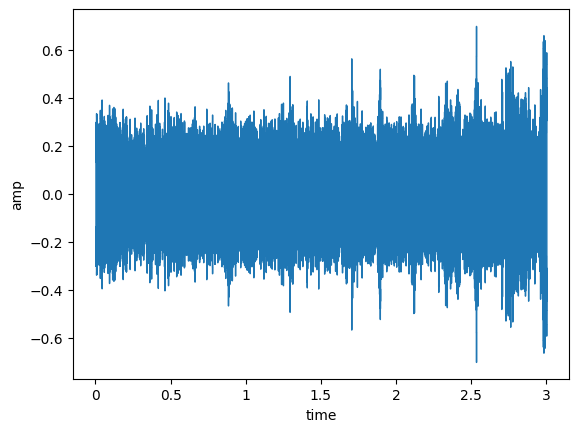

In [11]:
# ------------------------------------------------------------
# 📝 Exercise 5 – Visualizing audio data: Waveforms
# ------------------------------------------------------------
# How are audio classification networks able to do what they do? A lot of this
# has to do with the representation used for the audio itself when it is input
# to the network. Let's explore some options here.
#
# The first way that audio is commonly represented is as a *waveform* which
# shows amplitude vs. time. Let's see what this looks like.
#
# 1. Select an example audio file containing your TARGET species. Play the clip using
#    your play_audio method from above. Choose a clip where your species is clearly audible.
#
# 2. Use librosa.display.waveshow to display the waveform of your audio. Use plt.xlabel
#    and plt.ylabel to correctly label the axes.

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
import librosa.display
sample_row = solo_df.iloc[100]
sample_fp = filepath_from_row(sample_row)
play_audio(sample_row)
audio, sr = librosa.load(sample_fp, sr=None)
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('time')
plt.ylabel('amp')

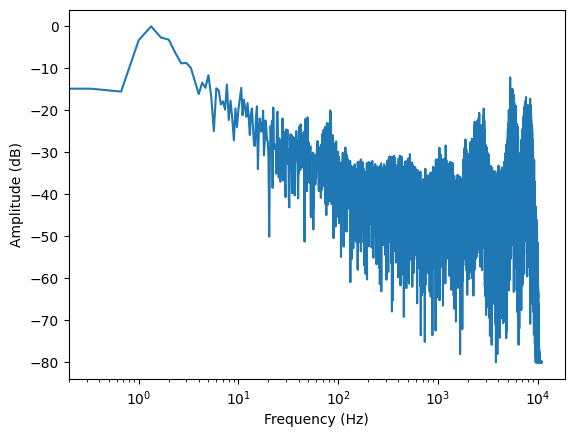

In [12]:
# ------------------------------------------------------------
# Visualizing audio data: Fourier transforms
# ------------------------------------------------------------
# Waveforms are useful for identifying transient events -- i.e. instantaneous
# sharp changes in signal amplitude -- but they are not extremely useful for
# classifying what is there. This is because we perceive audio *frequencies*, i.e,
# modulations of amplitude at a certain rate over time. This is hard to see in
# waveform diagrams.
#
# Let's try transforming our sample clip with a discrete Fourier Transform (DFT),
# which decomposes an audio signal into the set of frequencies it contains.
# ------------------------------------------------------------

# assumes your audio file, loaded from librosa, is stored as `audio`
dft = np.fft.rfft(audio)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sr, n_fft=len(audio))

plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

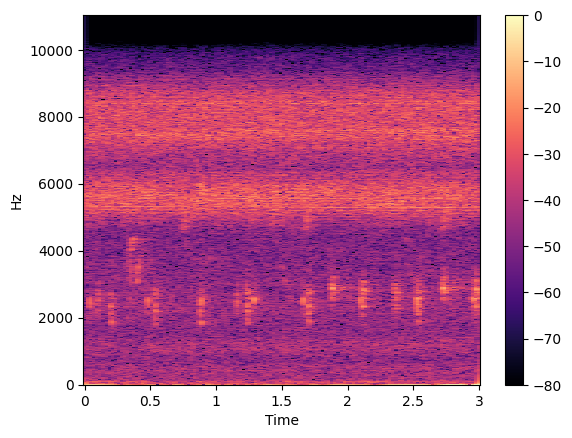

In [13]:
# ------------------------------------------------------------
# 📝 Exercise 6a – Visualizing audio data: Spectrograms
# ------------------------------------------------------------
# This is starting to look more interpretable -- we can see whether our file contains
# more low-frequency or high-frequency content, which may point to what it contains.
# But this is still a summary of the entire clip; it would be useful to see how frequency
# content changes over time. What if we took a lot of DFTs, each over a short window of time,
# and then arranged them sequentially to see how frequency content changes over time? A 
# *spectrogram* does exactly this.
#
# Spectrograms have contributed to much much of recent success in audio classification. 
# Perhaps surprisingly, this is also related to advancements in *computer vision*. As we
# will see, the visual representation offered by a spectrogram is informative enough that
# we can train visual classification networks with them. This allows us to use standard 
# computer vision classifiers rather than having to build custom neural network architectures 
# for audio.
# 
# The pre-trained models we will use, YAMNet and Perch, perform the conversion from
# audio to spectrogram behind the scenes before data hits the computer vision model.
# Still, it is useful to understand what these spectrograms actually look like. Let's 
# create one ourselves for the same sample clip you have been using.
#
# 1. Plot a spectrogram of your sample audio file. To do this, 
#    (i) use librosa.stft (short-time Fourier Transform) to compute the DFT over all short time windows
#    (ii) convert amplitude to decibels using librosa.amplitude_to_db (reference the cell above)
#         and display it with librosa.specshow.
# ------------------------------------------------------------

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
D = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

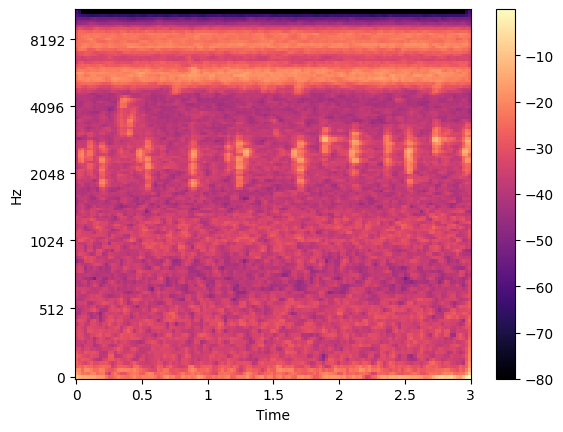

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 6b – Visualizing audio data: Mel spectrograms
# ------------------------------------------------------------
# A mel spectrogram is a variation of the spectrogram that is commonly used in speech processing and 
# machine learning tasks. It is similar to a spectrogram in that it shows the frequency content of an 
# audio signal over time, but on a different frequency axis. In a standard spectrogram, the frequency 
# axis is linear and is measured in hertz (Hz). However, the human auditory system is more sensitive 
# to changes in lower frequencies than higher frequencies, and this sensitivity decreases logarithmically 
# as frequency increases. The mel scale is a perceptual scale that approximates the non-linear frequency 
# response of the human ear. [Lovely description sourced from HuggingFace audio; I couldn't do any better myself!]
#
# To create a mel spectrogram, the STFT is used just like before, splitting the audio into short segments 
# to obtain a sequence of frequency spectra. Additionally, each spectrum is sent through a set of filters, 
# the so-called mel filterbank, to transform the frequencies to the mel scale. 
# 
# 1. Use librosa.feature.melspectrogram to create a mel spectrogram of your sample clip. Again, convert to db
#    and display with librosa.display.specshow.
# ------------------------------------------------------------

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
S = librosa.feature.melspectrogram(y=audio, sr=sr) #, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr) #, fmax=8000)
plt.colorbar()

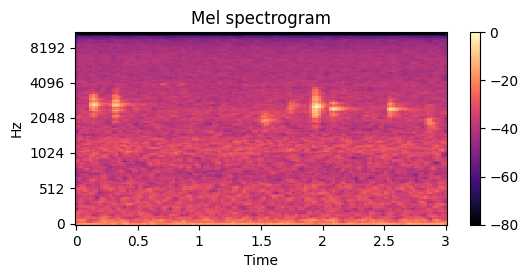

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 6 - Object-oriented practice
# ------------------------------------------------------------
# We keep passing around filepaths, audio arrays, dataframe rows, etc. etc.
# This is a bit cumbersome. What if we could think of our audio file as a 
# discrete *object* that we could ask things of (e.g., please show me your spectrogram)?
# 
# This is the idea behind *object-oriented programming* (OOP). We will use OOP extensively
# throughout this workshop. As a simple example, let's define an AudioSample *class*
# that encapsulates all the functionality we want from an audio file. Then, we can 
# simply make calls to it later and don't have to duplicate a bunch of code.
#
# Fill in the class definition below.
# ------------------------------------------------------------
class AudioSample:
    def __init__(self, filepath: Path):
        """
        The __init__ method is called automatically whenever you create an
        AudioSample object. We can use this to store *instance variables* 
        within the object using self.variable_name = variable_value.
        """
        self.filepath = filepath

        # We will use the *lazy loading* paradigm: we won't load audio from
        # disk until we actually need to use it.
        self._audio = None
        self._sr = None

    def get_audio_and_sr(self):
        """
        Return self._audio and self._sr.
        hint: load them (using librosa) if they are not already loaded!
        """
        raise NotImplemented
        return self._audio, self._sr
    
    def play(self):
        raise NotImplemented

    def plot_spectrogram(self):
        raise NotImplemented

sample_idx = 0
sample_file = AudioSample(filepath_from_row(solo_df.iloc[sample_idx]))
sample_file.play()
sample_file.plot_spectrogram()

# ------------------------------------------------------------
# SOLUTION
# ------------------------------------------------------------
class AudioSample:
    def __init__(self, filepath: Path):
        """
        The __init__ method is called automatically whenever you create an
        AudioSample object. We can use this to store *instance variables* 
        within the object using self.variable_name = variable_value.
        """
        self.filepath = filepath

        # We will use the *lazy loading* paradigm: we won't load audio from
        # disk until we actually need to use it.
        self._audio = None
        self._sr = None

    def get_audio_and_sr(self):
        """
        Return self._audio and self._sr.
        hint: load them (using librosa) if they are not already loaded!
        """
        if self._audio is None:
            self._audio, self._sr = librosa.load(self.filepath, sr=None)
        return self._audio, self._sr
    
    def play(self):
        audio, sr = self.get_audio_and_sr()
        display(Audio(audio, rate=sr))

    def plot_spectrogram(self):
        audio, sr = self.get_audio_and_sr()
        S = librosa.feature.melspectrogram(y=audio, sr=sr)
        S_db = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(6,2.5))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(); plt.title('Mel spectrogram')

sample_idx = 0
sample_file = AudioSample(filepath_from_row(solo_df.iloc[sample_idx]))
sample_file.play()
sample_file.plot_spectrogram()